In [1]:
# !python -m venv env
# !pip install -r "C:/Users/msi/DS/Eye Disease Classification/requirements.txt"

In [2]:
# !pip install torch==2.1.0+cu116 torchvision==0.16.0+cu116 torchaudio==2.1.0+cu116 --index-url https://download.pytorch.org/whl/cu116

In [3]:
import os
import pandas as pd
import numpy as np
import kagglehub
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

C:\Users\msi\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Загружаем датасет (локально)

In [4]:
DATA_DIR = Path("C:/Users/msi/DS/Eye Disease Classification/dataset/Augmented Dataset")
TEST_DATA_DIR = Path("C:/Users/msi/DS/Eye Disease Classification/dataset/Original Dataset")
WORK_DIR = Path("C:/Users/msi/DS/Eye Disease Classification/workdir")

Формируем датасет как словарь структуры:

{
    "path": <путь к фото>,
    "class": <название класса>,
    "width": <ширина>,
    "height": <высота>
}

In [5]:
def load_eye_disease_dataset(
    DATA_DIR: str, force_download: bool = False
) -> pd.DataFrame:
    """
    Загружает и структурирует датасет
    Возвращает DataFrame с путями к изображениям и метками классов
    """

    # Выгружаем данные
    if force_download or not DATA_DIR.exists():
        print("Загружаю датасет...")
        DATA_DIR = kagglehub.dataset_download(
            "ruhulaminsharif/eye-disease-image-dataset"
        )
        print(f"Датасет загружен в директорию: {DATA_DIR}")
    else:
        print(f"Использую уже имеющийся датасет из директории: {DATA_DIR}")

    folders = os.listdir(DATA_DIR)
    # Собираем метаданные
    data = []
    for class_name in folders:
        class_dir = DATA_DIR / class_name
        if not class_dir.exists():
            continue

        for img_path in class_dir.glob("*.jpg"):
            try:
                # Проверка целостности изображений
                with Image.open(img_path) as img:
                    img.verify()

                data.append(
                    {
                        "path": str(img_path),
                        "class": class_name,
                        "width": img.width,
                        "height": img.height,
                    }
                )
            except (IOError, OSError) as e:
                print(f"Ошибка с изображением {img_path} - {str(e)}")

    # Формируем датафрейм
    df = pd.DataFrame(data)

    # Проверим распределение классов
    class_dist = df["class"].value_counts()
    print(f"Распределение классов: {class_dist}")

    if len(df) == 0:
        raise ValueError("Датасет пустой!")

    return df

In [6]:
df = load_eye_disease_dataset(DATA_DIR)
df.head()

Использую уже имеющийся датасет из директории: C:\Users\msi\DS\Eye Disease Classification\dataset\Augmented Dataset
Распределение классов: class
Diabetic Retinopathy                             3444
Glaucoma                                         2880
Healthy                                          2676
Myopia                                           2251
Macular Scar                                     1937
Retinitis Pigmentosa                              834
Disc Edema                                        762
Retinal Detachment                                750
Central Serous Chorioretinopathy-Color Fundus     606
Pterygium                                         102
Name: count, dtype: int64


,path,class,width,height
0,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690
1,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690
2,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690
3,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690
4,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690


Разделяем выборку на трейн/тест

In [7]:
# Проиндексируем наши классы
class_names = df["class"].unique().tolist()
class_idxs = {cls: i for i, cls in enumerate(class_names)}
class_labels = df["class"].map(class_idxs)
df["label"] = class_labels

# Теперь делим на трейн/тест
train_part, test_part = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

Выполняем нормализацию данных

In [8]:
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

Создаем свой кастомный Dataset

In [9]:
from torchvision.io import read_image


class EyeDiseaseDataset(Dataset):
    """
    Кастомный датасет
    """

    def __init__(self, df: pd.DataFrame, transform=None):
        self.data = df.reset_index(drop=True)
        self.transform = transform or transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img_path = self.data.loc[idx, 'path']
        image = Image.open(img_path).convert("RGB")
        label = self.data.loc[idx, 'label']
        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
train_ds = EyeDiseaseDataset(train_part, data_transforms['train'])
test_ds = EyeDiseaseDataset(test_part, data_transforms['test'])

Сделаем балансировку классов

In [11]:
from torch.utils.data import WeightedRandomSampler

class_counts = train_part["label"].value_counts().sort_index().values
class_weights = 1.0 / class_counts
weights = [class_weights[label] for label in train_part["label"]]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

Теперь создаем DataLoader

In [12]:
batch_size = 1000
num_workers = 8
train_dataloader = DataLoader(
    train_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    sampler=sampler
    # shuffle=True,
)


test_dataloader = DataLoader(
    test_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)

Проитерируемся и посмотрим на изображения

In [13]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plt.imshow(np.clip(img, 0, 1))

In [14]:
# train_features, train_labels = next(iter(train_dataloader))
# print(f"Размерность признаков: {train_features.size()}")
# print(f"Размерность классов: {train_labels.size()}")

# for i in range(5):
#     img = train_features[i]
#     label = train_labels[i]
#     imshow(img)
#     plt.title(class_names[train_labels[i].item()])
#     plt.show()


In [15]:
# Определим число классов
out_features = len(class_names)

Строим модель-бэзлайн - сверточную нейронную сеть

In [16]:
class NeuralNet(nn.Module):
    """
    Нейронная сеть для классификации изображений глазного дна
    """
    def __init__(self, out_features):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),  # 224/4=56
            nn.ReLU(),
            nn.Linear(128, out_features)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


In [17]:
nn_model = NeuralNet(out_features)
print(nn_model)

NeuralNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


Берем предобученный ResNet50

In [18]:
# from torchvision.models import resnet50

# resnet_model = resnet50(weights="IMAGENET1K_V1")
# num_ftrs = resnet_model.fc.in_features
# resnet_model.fc = nn.Linear(num_ftrs, len(class_names))
# resnet_model = resnet_model.to(
#     torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# )

Определим функции тренировки модели и визуализации предсказаний

In [19]:
from tempfile import TemporaryDirectory
from tqdm import tqdm


def train_model(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Adam,
    scheduler: lr_scheduler.StepLR,
    num_epochs=1000,
):
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        dataset_sizes = {"train": len(train_ds), "val": len(test_ds)}
        dataloaders = {"train": train_dataloader, "val": test_dataloader}

        print(f"Обучаю на cpu")

        for epoch in tqdm(range(num_epochs)):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == "train":
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")

                # deep copy the model
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        print(f"Best val Acc: {best_acc:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in test_dataloader:

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(
                    f"predicted: {class_names[preds[j]]}, \n real: {class_names[labels[j]]}"
                )
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Обучаем нашу нейронную сеть

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# resnet_model = train_model(resnet_model, criterion, optimizer, scheduler, num_epochs=1)
nn_model = train_model(nn_model, criterion, optimizer, scheduler, num_epochs=1)

Обучаю на cpu


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Epoch 0/0
----------


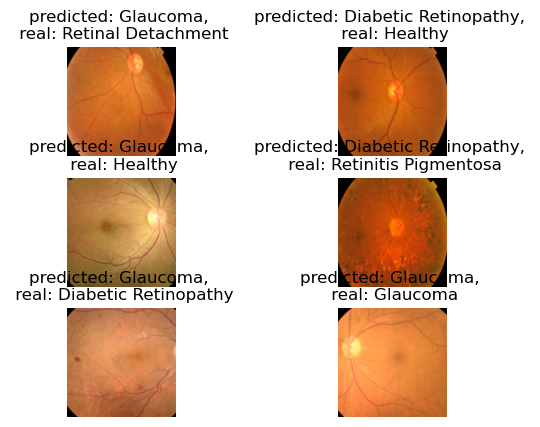

In [ ]:
visualize_model(nn_model)

In [ ]:
# torch.save(resnet_model.state_dict(), WORK_DIR / "resnet50.pth")
torch.save(nn_model.state_dict(), WORK_DIR / "nn.pth")

Проводим тестирование обученной модели

In [ ]:
# resnet_model = models.resnet50()
# resnet_model.load_state_dict(torch.load(WORK_DIR / "resnet50.pth"))
nn_model = NeuralNet(out_features)
nn_model.load_state_dict(torch.load(WORK_DIR / "nn.pth"))

<All keys matched successfully>

In [ ]:
test_df = load_eye_disease_dataset(TEST_DATA_DIR)
test_df.head()

Использую уже имеющийся датасет из директории: C:\Users\msi\DS\Eye Disease Classification\dataset\Original Dataset
Распределение классов: class
Diabetic Retinopathy                             1509
Glaucoma                                         1349
Healthy                                          1024
Myopia                                            500
Macular Scar                                      444
Retinitis Pigmentosa                              139
Disc Edema                                        127
Retinal Detachment                                125
Central Serous Chorioretinopathy-Color Fundus     101
Pterygium                                          17
Name: count, dtype: int64


,path,class,width,height
0,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690
1,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690
2,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690
3,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690
4,C:\Users\msi\DS\Eye Disease Classification\dat...,Central Serous Chorioretinopathy-Color Fundus,2004,1690


Присваиваем метки

In [ ]:
test_df["label"] = test_df["class"].map(class_idxs)

Формируем датасет

In [ ]:
test_ds = EyeDiseaseDataset(test_df, data_transforms["test"])
test_dataloader = DataLoader(
    test_ds, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

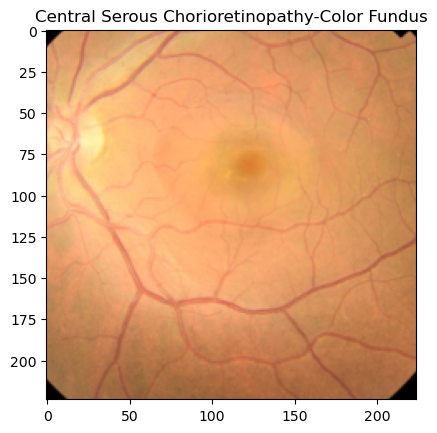

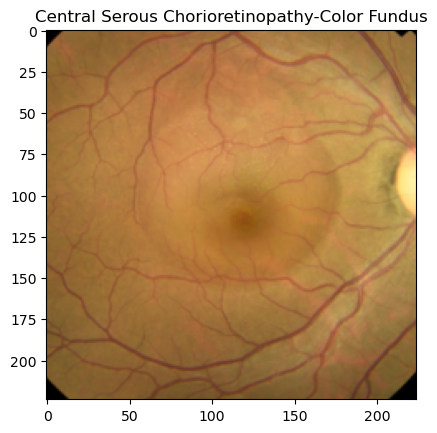

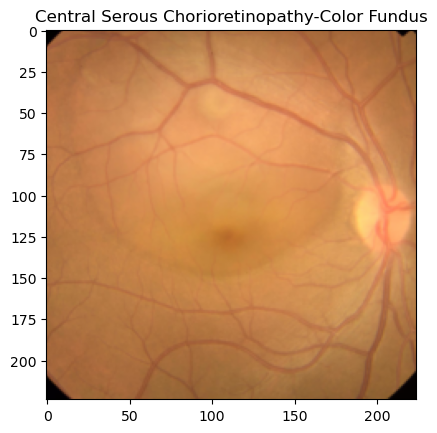

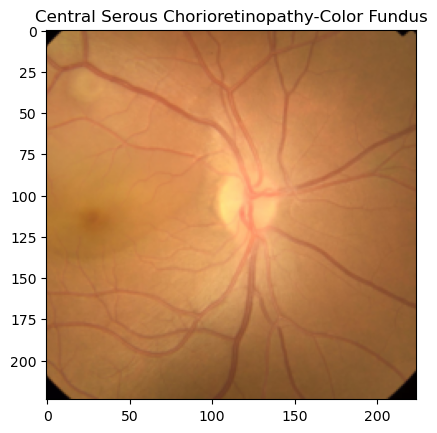

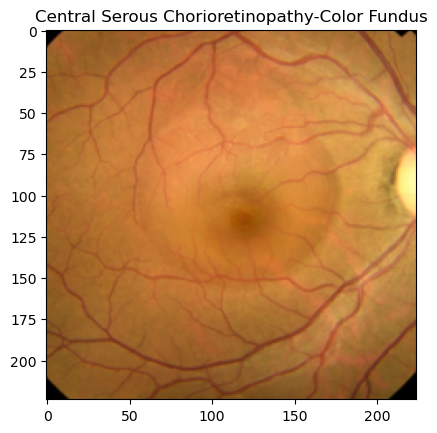

In [ ]:
test_features, test_labels = next(iter(test_dataloader))

for i in range(5):
    img = test_features[i]
    label = test_labels[i]
    imshow(img)
    plt.title(class_names[test_labels[i].item()])
    plt.show()

Прогнозируем с обученным resnet50

In [ ]:
from torch.nn.functional import softmax

# resnet_model.eval()
# resnet_model = resnet_model.to(device)
nn_model.eval()
y_true = []
y_pred = []
y_probas = []

for inputs, labels in test_dataloader:
    with torch.no_grad():
        # outputs = resnet_model(inputs)
        outputs = nn_model(inputs)
        probas = softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probas.extend(probas.cpu().numpy())

#### Оценим качество модели resnet50
##### Выведем accuracy, precision, recall, F1...

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

print(
    classification_report(
        y_true,
        y_pred,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

                                               precision    recall  f1-score   support

Central Serous Chorioretinopathy-Color Fundus       0.00      0.00      0.00       101
                         Diabetic Retinopathy       0.58      0.39      0.47      1509
                                   Disc Edema       0.00      0.00      0.00       127
                                     Glaucoma       0.28      0.87      0.43      1349
                                      Healthy       0.00      0.00      0.00      1024
                                 Macular Scar       0.00      0.00      0.00       444
                                       Myopia       0.38      0.13      0.19       500
                                    Pterygium       0.00      0.00      0.00        17
                           Retinal Detachment       0.00      0.00      0.00       125
                         Retinitis Pigmentosa       0.00      0.00      0.00       139

                                     accu

C:\Users\msi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\msi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([ 101., 1509.,  127., 1349., 1024.,  444.,  500.,   17.,  125.,
         139.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

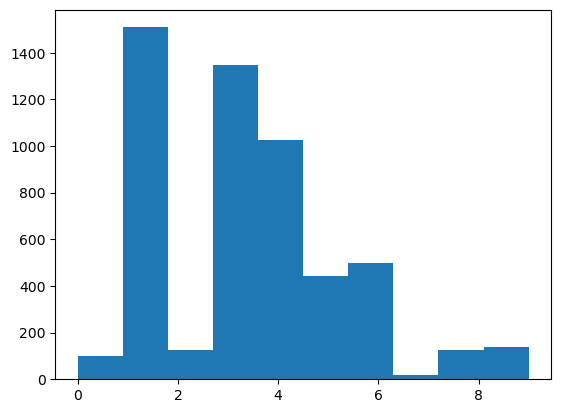

In [ ]:
# Проверка распределения меток в семплере
batch_labels = []
for images, labels in test_dataloader:
    batch_labels.extend(labels.numpy())
plt.hist(batch_labels, bins=len(class_names))

In [ ]:
print(roc_auc_score(y_true, y_probas, multi_class='ovr'))

0.7014917485037522


In [ ]:
accuracy_score(y_true, y_pred)

0.3422680412371134